# Tutorial 9 - Using NumBAT in Jupyter Notebooks

For those who like to work in an interactive fashion,
NumBAT works perfectly well inside a Jupyter notebook. 
This is demonstrated in the file ``jup_09_smf28.ipynb`` using the standard
SMF-28 fibre problem as an example.

On a Linux system, you can open this at the command line with::

  $ jupyter-notebook ``jup_09_smf28.ipynb``

or else load it directly in an already open Jupyter environment.

The notebook demonstrates how to run standard NumBAT routines step by step.
The output is still written to disk, so the notebook includes some simple techniques for 
efficiently displaying mode profiles and spectra inside the notebook. 

### Make some standard inputs.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display
import glob
import numpy as np

In [5]:
sys.path.append("../backend/")  # or whereever you have NumBATApp installed
import numbat
import materials
import structure
import mode_calcs
import integration
import plotting
#from fortran import numbat


### Specify the geometry

In [3]:
wl_nm = 1550
domain_x = 5*wl_nm
domain_y = domain_x
inc_a_x = 550
inc_a_y = inc_a_x
inc_shape = 'circular'

num_modes_EM_pump = 20
num_modes_EM_Stokes = num_modes_EM_pump
num_modes_AC = 40
EM_ival_pump = 0
EM_ival_Stokes = 0
AC_ival = 'All'


### Make the structure

In [ ]:
prefix = 'tut_16'
nbapp = numbat.NumBATApp(prefix)

mat_bkg = materials.make_material("Vacuum")
mat_a   = materials.make_material("SiO2_2016_Smith")


wguide = nbapp.make_structure(domain_x,inc_a_x,domain_y,inc_a_y,inc_shape,
                          material_bkg=mat_bkg, material_a=mat_a,
                          lc_bkg=.1, lc_refine_1=10, lc_refine_2=10)

Building mesh


### Calculate the EM modes

In [7]:
neff_est = 1.4

sim_EM_pump = wguide.calc_EM_modes(num_modes_EM_pump, wl_nm, n_eff=neff_est)

Calculating EM modes:
 Boundary conditions: Periodic

 Structure has 2089 mesh points and 1024 mesh elements.

 -----------------------------------------------
 EM FEM: 
      - assembling linear system for adjoint solution    
           cpu time  =   0.17 secs.
           wall time =   0.18 secs.
      - solving linear system
           cpu time  =  17.79 secs.
           wall time =   1.66 secs.
 EM FEM: 
      - assembling linear system for prime solution      
           cpu time  =   0.17 secs.
           wall time =   0.17 secs.
      - solving linear system
           cpu time  =  15.22 secs.
           wall time =   1.43 secs.
 -----------------------------------------------

  Calculating EM mode powers...


Find the backward Stokes fields

In [ ]:
sim_EM_Stokes = sim_EM_pump.clone_as_backward_modes()

### Generate EM mode fields

We are now ready to plot EM field profiles, but how many should we ask for?

The $V$-number of this waveguide can be estimated as $V=\frac{2 \pi a}{\lambda} \sqrt{n_c^2-n_{cl}^2}$:

In [ ]:
V=2 *pi/wl_nm * inc_a_x * np.sqrt(np.real(mat_a.refindex_n**2
                                  - mat_bkg.refindex_n**2))
print('V={0:.4f}'.format(V))

V=2.3410


We thus expect only a couple of guided modes and to save time and disk space, only ask for the first few to be generated:

In [10]:
sim_EM_pump.plot_modes(EM_AC='EM_E',
        xlim_min=0.2, xlim_max=0.2, ylim_min=0.2, ylim_max=0.2,
         ivals=range(5))




Checking triangulation goodness
  Closest space of triangle points was 2.4024988779778966e-08
  No doubled triangles found

  Structure has raw domain(x,y)   = [-3.87500, 3.87500] x [ -3.87500, 3.87500] (um),
                mapped to (x',y') = [-3.87500, 3.87500] x [ -3.87500, 3.87500] (um)
                    
Plotting em modes m=0 to 4.


Get a list of the generated files. By sorting the list, the modes will be in order from lowest ($m=0$) to highest.

In [12]:
emfields = glob.glob(prefix+'-fields/EM*.png')
emfields.sort()

In Jupyter, we can display images using the `display(Image(filename=f))` construct.



 tut_16-fields/EM_E_mode_00.png


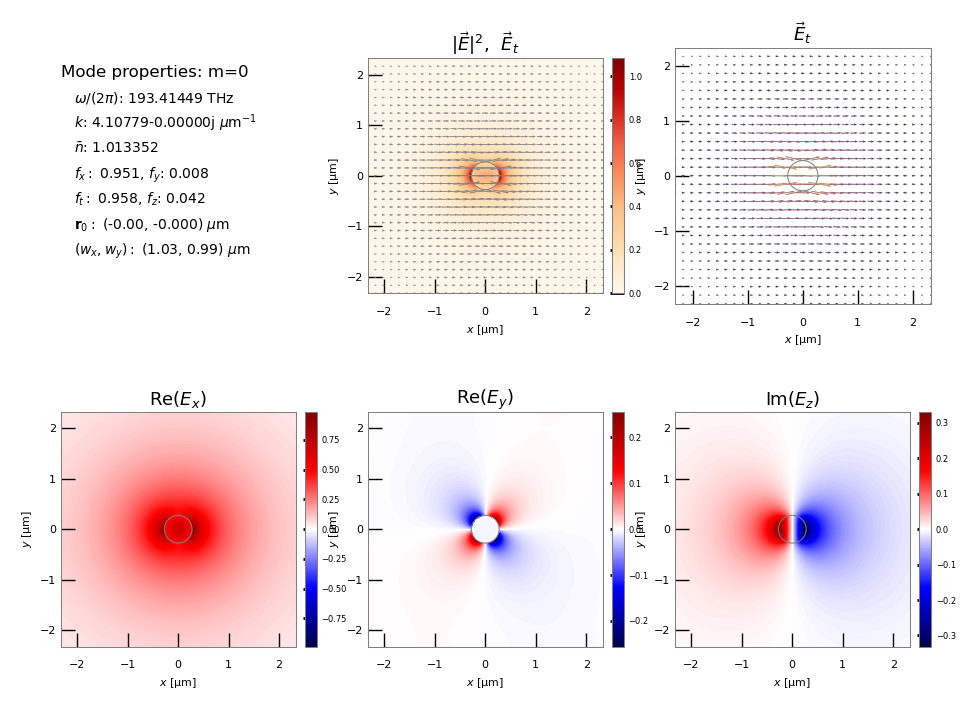



 tut_16-fields/EM_E_mode_01.png


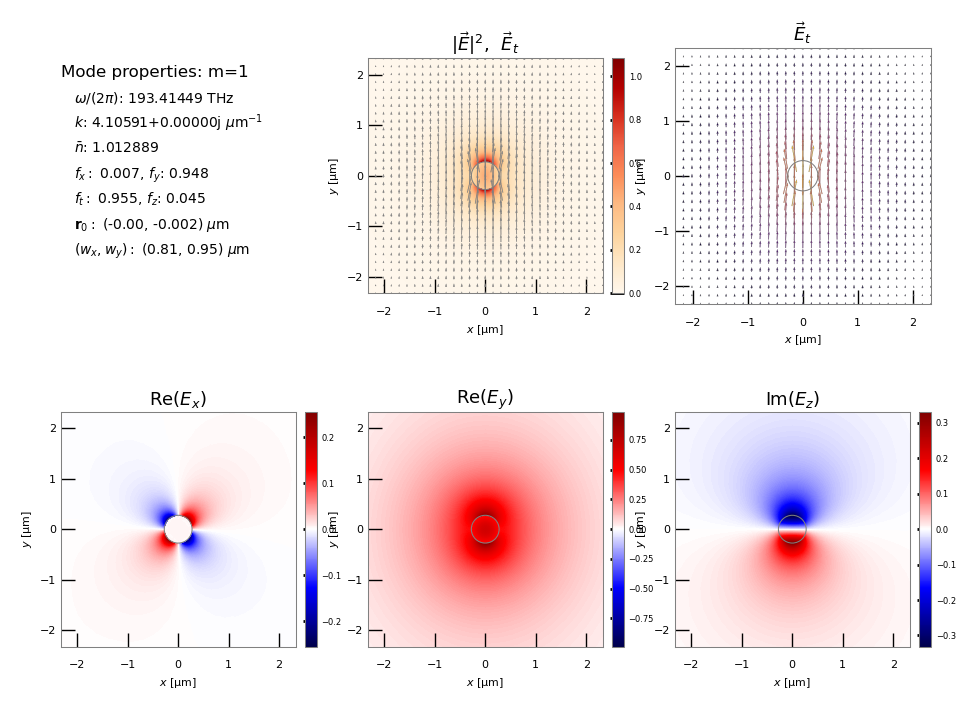



 tut_16-fields/EM_E_mode_02.png


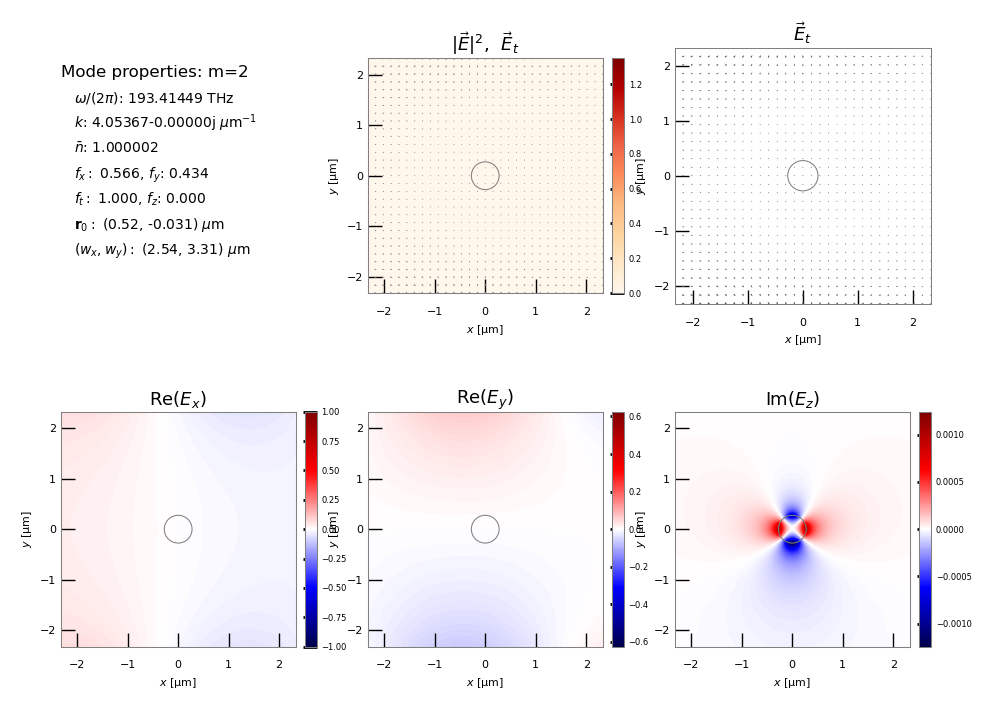

In [13]:
for f in emfields[0:3]:
    print('\n\n',f)
    display(Image(filename=f))

### Calculate the acoustic modes

Now let's turn to the acoustic modes.

For backwards SBS, we set the desired acoustic wavenumber to the difference between the pump and Stokes wavenumbers.
        $\Omega$
    We specify a 'shift' frequency as a starting location of the frequency to look for solutions 

In [14]:
q_AC = np.real(sim_EM_pump.kz_EM(EM_ival_pump) - sim_EM_Stokes.kz_EM(EM_ival_Stokes))

NuShift_Hz = 4e9

sim_AC = wguide.calc_AC_modes(num_modes_AC, q_AC, EM_sim=sim_EM_pump, shift_Hz=NuShift_Hz)




Calculating AC modes

 Structure has 273 mesh points and 124 mesh elements.

 -----------------------------------------------
 AC FEM: 
       - assembling linear system
           cpu time  =   0.00 secs.
           wall time =   0.00 secs.
       - solving linear system
           cpu time  =   0.77 secs.
           wall time =   0.05 secs.
 -----------------------------------------------



In [15]:
sim_AC.plot_modes( ivals=range(10))



Checking triangulation goodness
  Closest space of triangle points was 2.4024988779778966e-08
  No doubled triangles found

  Structure has raw domain(x,y)   = [-0.27500, 0.27500] x [ -0.27500, 0.27500] (um),
                mapped to (x',y') = [-0.27500, 0.27500] x [ -0.27500, 0.27500] (um)
                    
Plotting acoustic modes m=0 to 9.


In [16]:
acfields = glob.glob(prefix+'-fields/AC*.png')
acfields.sort()




 tut_16-fields/AC_mode_00.png


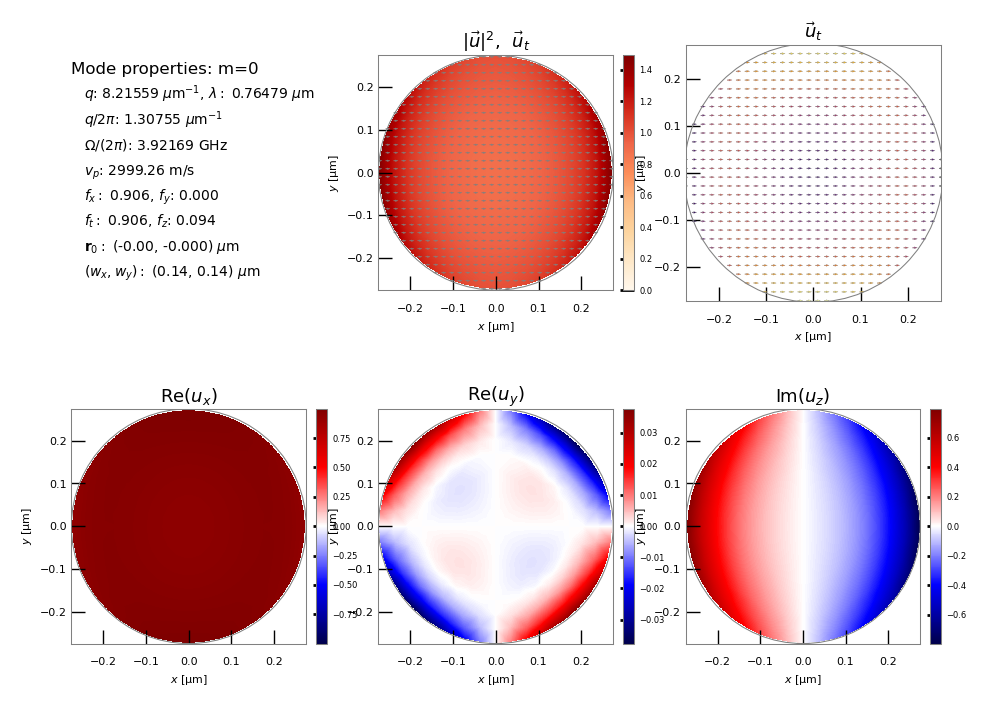



 tut_16-fields/AC_mode_01.png


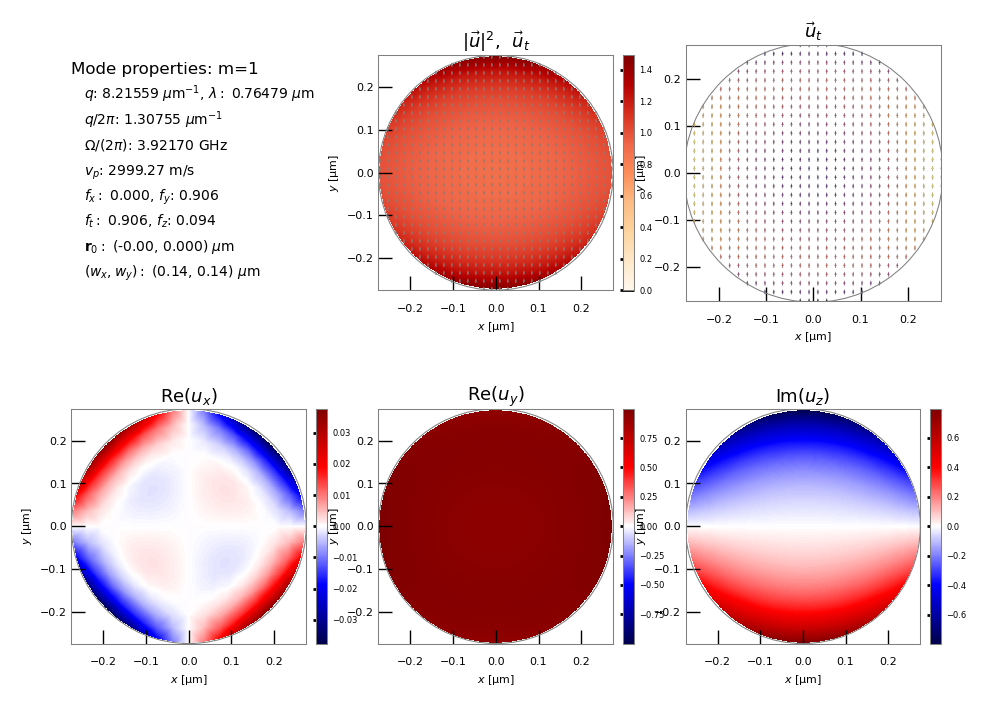



 tut_16-fields/AC_mode_02.png


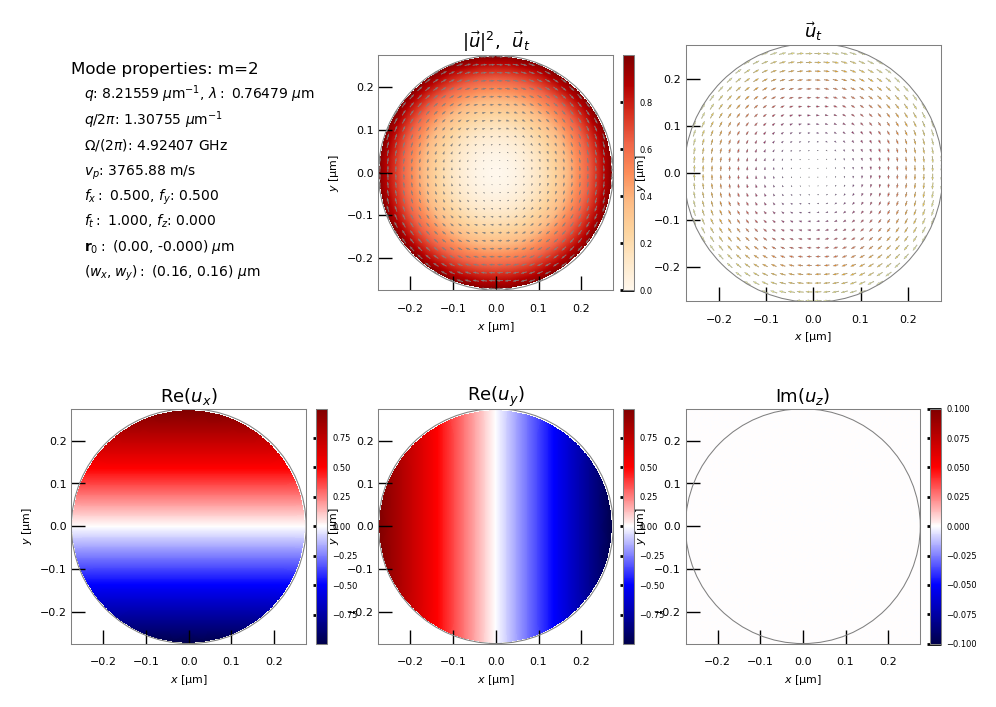



 tut_16-fields/AC_mode_03.png


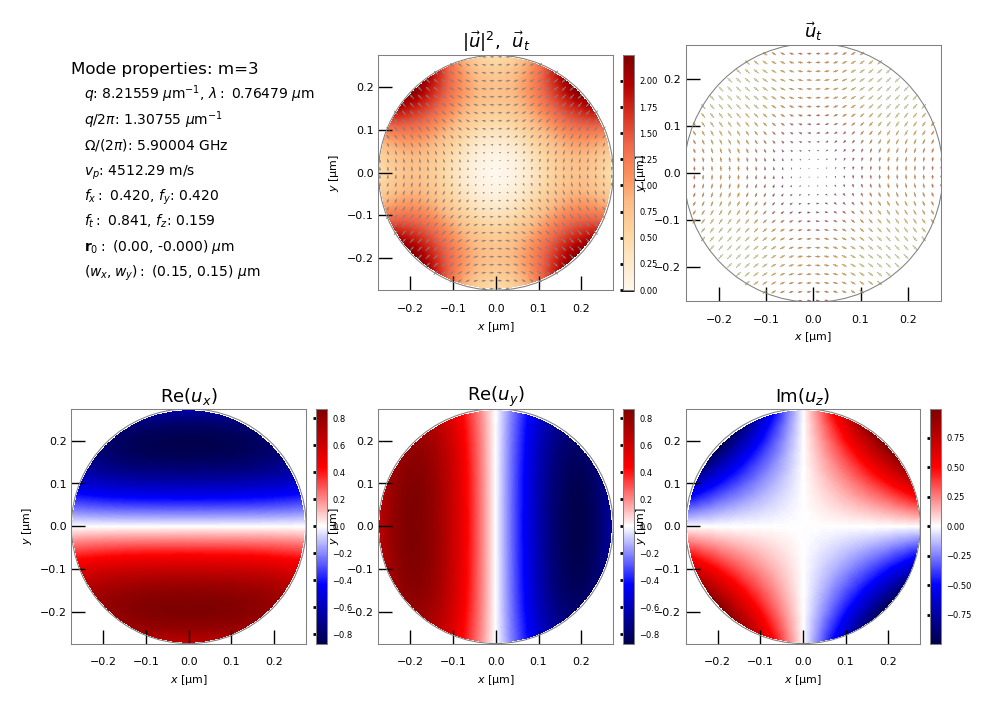



 tut_16-fields/AC_mode_04.png


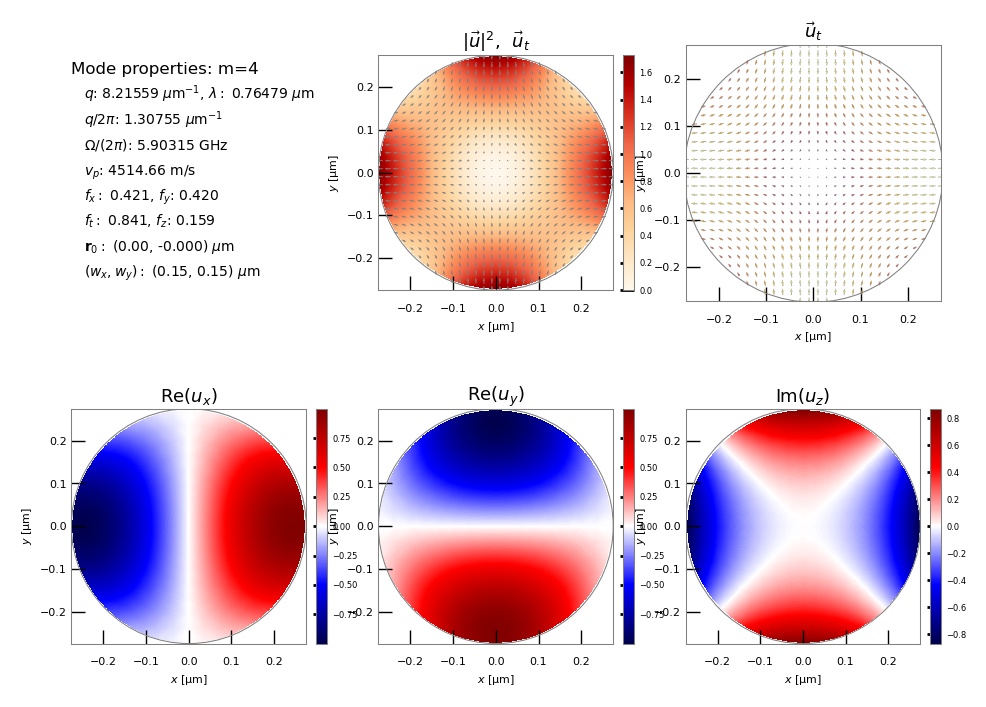



 tut_16-fields/AC_mode_05.png


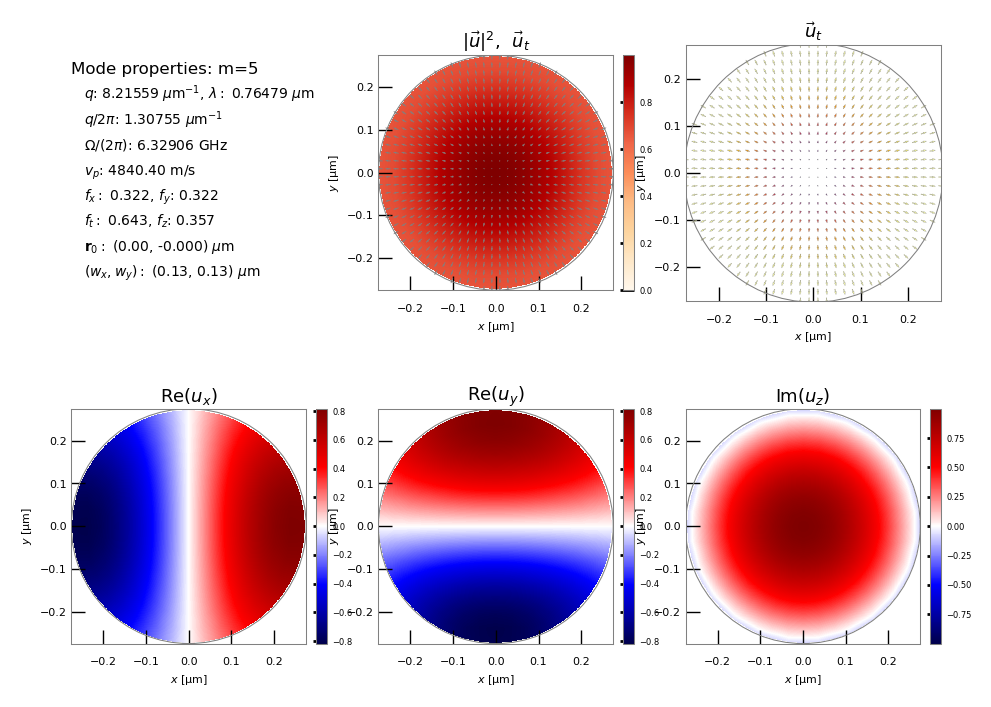

In [17]:
for f in acfields[0:6]:
    print('\n\n',f)
    display(Image(filename=f))